# Clustering

In most datasets, the data is not spread uniformly in the phase space.
The underlying purpose of data science is precisely to undercover patterns in the data.
In some use cases, we wish to identify subgroups of homogeneous instances.
This strategy is called clustering.

Clustering may have many usages.
First, it is a way to analyse customer behaviour and create marketing archetypes.
Indeed, instead of marketing a product the same way for all propects, it is interesting to identify homogeneous subgroups of customers with different purchase behaviour.
Then you can adapt the message to the specific drives of the customers.

Clustering may also be used as a preprocessing tool for machine learning.
Indeed, the machine learning algorithm may not be able to create only complex frontiers around clusters.
Combining dimension reduction and clustering may help in creating communities.
Then, the engineer may use the group id as a categorical features and perform visualisation or category encoding on it.

There is a wide variety of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html), with different strategies and implementations.
Here we will present the most popular and very differents ones.

Clustering algorithms look by definition at the distances between points.
As a result, the notion of distance must not be considered lightly.
Changing the notion of distance may lead to very different results.
Students are encouraged to follow the lesson about dimension reduction, where a more thorough discussion about metrics is presented.

## Syllabus

* Overview of main clustering algorithms,
* Study of algorithms behaviours under specific data,
* Techniques to evaluate the quality of the clustering.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src import *
from sklearn.mixture import GaussianMixture

## KMeans

The first algorihtm that we will discuss is called KMeans.
This algorithm defines N archetypes, which correspond to brand new instances.
The objective of those archetypes is to be at the center of each of the subgroups in the dataset.
They are some sort of group leaders, or an average Joe of the group.
The objective of the KMeans algorithm is to optimise the position of those archetypes so that they end up in the middle of a densily populated area.

The algorithm works [as follow](http://shabal.in/visuals/kmeans/2.html).
* First, choose the number of archetypes. In KMeans, it is the analyst duty to determine the number of clusters, by imposing a number of initial archetypes. We will see later how to choose this number.

* Then choose the initial position of these archetypes. 

* Each points will then belong to the group of the closest archetype.
   The euclidian metric is used in most implementation but is open to changes in theory. 

* Move the archetype to be at the barycenter of all the instances it has been attributed to.

* Repeat the last two steps until convergence.

![http://shabal.in/visuals/kmeans/2.html](../../figures/kmeans.gif)


### n_clusters overshoot

One issue with KMeans is that the analyst must provide the number of archetypes, which in theory must match the number of natural cluster.
Most of the time, the natural number of cluster is difficult to evaluate.
For example, you can't see in high dimension so it is complicated to estimate if there are any clusters at all.
On the other hand, clusters may not be extremely well defined.
As a result, it can be tricky even for a human to estimate the number of clusters.

The objective of KMeans is to find the best position for an archetype, not to tell if this archetype is meaningful.
Let's look at what happen if we overshoot the number of natural clusters.
Along this section, we will focus on a synthetic dataset with 3 clear clusters.

In [ ]:
from sklearn.datasets import make_blobs
limit = 4
data, labels = make_blobs(300, random_state=12,
                         centers = [[0, 0], [-limit, limit], [-limit, -limit]])

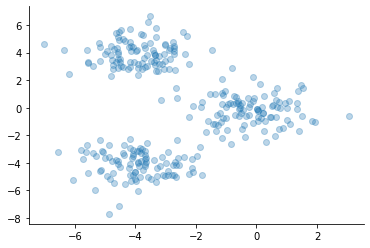

In [ ]:
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], alpha=0.3);

In these data, we have 3 natural clusters but we will ask KMeans to find 5.

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
preds = kmeans.fit_predict(data)

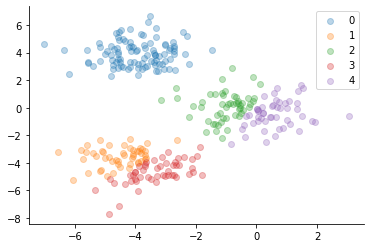

In [ ]:
fig, ax = plt.subplots()
for label in np.unique(preds):
    mask = preds==label
    ax.scatter(data[mask,0], data[mask,1], label=label, alpha=0.3)
ax.legend();

We asked KMeans to identify 5 clusters.
So 5 archetypes are created, even though only 3 real clusters exist.
As a result, the algorithm created two clusters out of a single one by roughly splitting it in two.
Finally, 4 of those identified clusters are not meaningful by themselves.
We need to merge them.
We will see later metrics that can help us identify this phenomena if we can't actually see the clusters.

### cluster size

In practice, not all clusters are expected to have the same size.
Some are densily populated while others are more spread.
KMeans do not consider this when attributing ownership of instances to archetypes.
The only metric is the distance to said archetypes.
This can lead to situations as below.
Even though the correct archetypes have been found, instances are not always attributed to the right one because of the large difference in spread of each cluster.

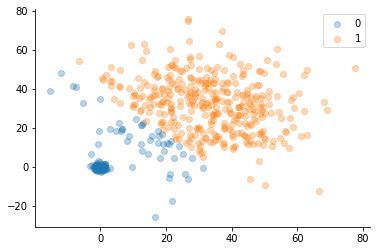

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[100, 400], 
                          random_state=12,
                         centers = [[0, 0], [30, 30]], 
                         cluster_std=[1, 15])

kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(data)
plot_clustering(data, labels)

### fuzzy

The attribution of each point to a cluster with KMeans depends only on its distance to the various centroids, and not on its neighbours.
This means that KMeans is perfectly able to create cluster when the frontier between them is fuzzy.
KMeans will draw a line between the two clusters.
Even though the points at the frontier may not be attributed to their native cluster, KMeans is still able to recreate most of the two clusters in the following example.

When attributing a cluster to a point, KMeans does not consider the distance to the closest cluster as long as it is the smallest.
In the example below, 3 outlier points have been added.
KMeans treat them as any other points even though they are far from belonging in the blue cluster.

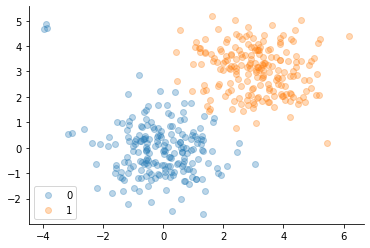

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[3, 200, 200], 
                          random_state=12,
                         centers = [[-4, 5], [0, 0], [3, 3]], 
                         cluster_std=[0.2, 1, 1])

kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(data)
plot_clustering(data, labels)

### Forget complex shapes

KMeans is adapted for circular clusters, or at least clusters separable by a straight line.
If clusters have non linear frontier, KMeans will cut both natural clusters in two parts.
The following example shows complex moon clusters and how KMeans fail at identifying them.

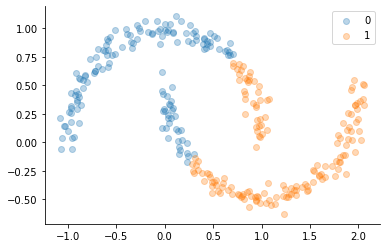

In [ ]:
from sklearn.datasets import make_moons
data, labels = make_moons(300, noise=0.06)

kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(data)
plot_clustering(data, labels)

## Gaussian mixture

Gaussian mixture (GM) is an improvement of the KMeans algorithm, over some limitations that we have cited so far.
This algorithm also tries to optimise the position of archetypes in the phase space.
However, it makes less strict assumptions than KMeans.
Instead of considering that the clusters must be spheres of same radius, GM suppose that the clusters follow the distribution of multi dimensional Gaussian.
This means that clusters can be elongated in any direction, and can have various spreads.


The GM algorithm works relatively similarly to the KMeans algorithms.
First, a user defined number of multi dimensional gaussian distribution are created.
Then, one estimates the probability that each point was generated by each distribution and attributes the point to the most probable gaussian.
Then, the parameters of the gaussian are updated in order to maximise the likelihood of the cluster data.

### Cluster shape

Because GM works very similarly to KMeans, is suffers from most of its limitations.
However, GM allows shapes of the clusters to be more complex than KMeans.
The algorithm can find extremely elongated clusters, which can also potentially overlap.

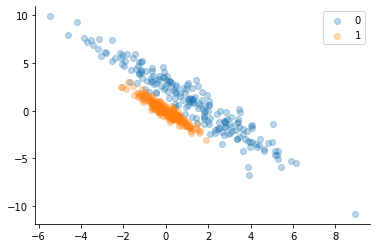

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[200, 200], 
                          random_state=12,
                         centers = [[0, 0], [5, 5]], 
                         cluster_std=[1, 3])
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
data = np.dot(data, transformation)

clst = GaussianMixture(n_components=2, random_state=0)
labels = clst.fit_predict(data)
plot_clustering(data, labels)

### Cluster size

Because GM allows the correlation matrix of each Gaussian component to be fitted on the data, it can adapt to cluster of different sizes.
If we look back at the example of large and small cluster from the KMeans  section, we see that GM is able to take into account the large spead of the blue clusters.
Even points relatively close to the orange cluster are attributed to the blue cluster.

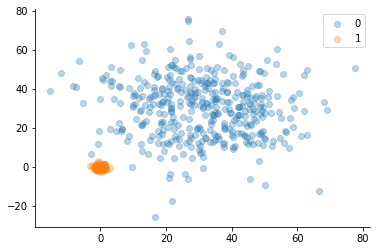

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[100, 400], 
                          random_state=12,
                         centers = [[0, 0], [30, 30]], 
                         cluster_std=[1, 15])
clst = GaussianMixture(n_components=2, random_state=0)
labels = clst.fit_predict(data)
plot_clustering(data, labels)

## DBSCAN

The DBSCAN algorithm is more oriented toward the neighbours of the point.
It first starts by selecting a random point and looks at how many other points are within a ball of radius ```eps``` set by the analyst.
If enough points belong to the neighbourhood, a cluster is created with them.
Then the algorithm will check the neighbourhood of added points and adds to the cluster any instance falls into it.
The cluster is extended as long as points are reachable.
When nothing is reachable anymore, the algorithm tries to create other clusters from points not yet tested.
If a tested point does not have enough points in his neighbourhood, then it is considered an outlier and no cluster is created.
The minimum number of points for a cluster is set by the user : ```min_samples```.

The following gif presents the whole process.
![Alt Text](../../figures/dbscan.gif)

The DBSCAN algorithm has a very different behaviour compared to KMeans.

Because the process is agglomerative the algorithm can create very complex shapes as long as points make the link.
For example KMeans would not be able to create this red circle in the example.

The DBSCAN algorithm just agglomerates points and has no notion of the relations between points.
This means that DBSCAN can not predict the cluster on which belong a new point.
A combination with KNN machine learning algorithm would be necessary in production.

DBSCAN is is not organised around number of cluster but aroud distance.
The number of clusters is known a posteriori. 
The largest the ```eps```, the further away a cluster may accumulate points, hence the algorithm will generate a lower number of clusters.
If ```eps``` is small, smaller gaps between points will more easily block the algorithm which will create new clusters.

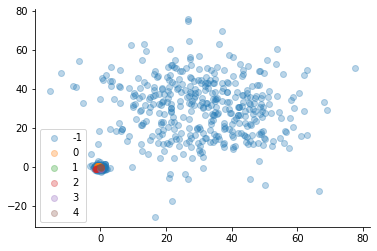

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.3)
labels = dbscan.fit_predict(data)
plot_clustering(data, labels)

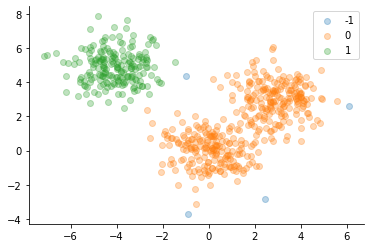

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
from sklearn.cluster import DBSCAN

data, labels = make_blobs(n_samples=[200, 200, 200], 
                          random_state=12,
                         centers = [[-4, 5], [0, 0], [3, 3]], 
                         cluster_std=[1, 1, 1])

dbscan = DBSCAN(eps=1)
labels = dbscan.fit_predict(data)
plot_clustering(data, labels)

Because of its greedy and agglomerative nature, DBSCAN is not adapted for fuzzy clustering, without well defined separation.
As long as there are a couple of points to make the junction, the cluster will keep expanding.
In the previous examples, the two orange clusters are merged because of the couple of points that allows the algorithm to jump from one cluster to the other.

### Density variations

DBSCAN has trouble dealing with cluster of varying density.
The ```eps``` parameter represents the standard distance that we expect from data points within a cluster.
But what would happen if we had a very compact cluster and an more light one, as in the example below.
If we set a very large ```eps``` for the light cluster, there is high chances that the small cluster would merge into the large.
Conversely, if we use a small ```eps```, then the large cluster would not be detected and all points are labelled as outliers.
This is what we observe in the following situation.
The analyst must then find a compromise when setting the ```eps``` parameter.

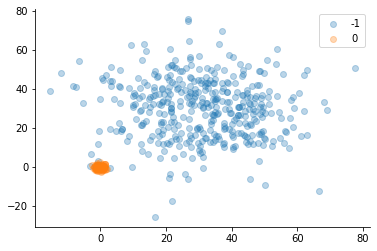

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[100, 400], 
                          random_state=12,
                         centers = [[0, 0], [30, 30]], 
                         cluster_std=[1, 15])

dbscan = DBSCAN(eps=1)
labels = dbscan.fit_predict(data)
plot_clustering(data, labels)

## Aglomerative clustering

Agglomerative clustering is another clustering technique based on neighbours.
It has a very simple concept.
The first step is to define each unique point to be a cluster on its own.
This is the maximal number of clusters that the dataset can have.
Then, the two closest clusters are combined into a larger cluster.
The iteration continues until all data are within un single master cluster that contains all the dataset.
The interesting part is that the algorithm keeps track of when two clusters where merged and what was the distance between those clusters.
As a result, we get a complete map of cluster distance from the master cluster to each individual points.
This map is usually presented as a binary tree, that allow the analyst to see the structure of the dataset and estimate where are the best cutting choice for the different branches in order to get the best clusters.

![Alt Text](../../figures/agglomerative_clustering.gif)

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[100, 400], 
                          random_state=12,
                         centers = [[0, 0], [30, 30]], 
                         cluster_std=[1, 15])

The most agile way of performing hierarchical clustering is not ```sklearn``` but the lower level library ```scipy```.
First we need to organise the data into hierachical cluster with the help of the ```linkage``` function.
The result will contain all the raw clusters to manipulate.
Then, the ```dendogram``` function is merely meant to visualize the result.

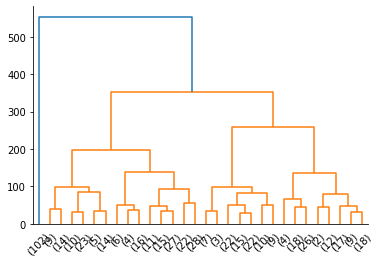

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data, 'ward')
fig, ax = plt.subplots()
dendrogram(Z, truncate_mode='lastp', p=30,);

In the previous graph, the length of vertical represents the distance between two merged clusters.
The longer the line, the further away were the clusters.
Then, identifying long vertical lines allows to identify were an unnatural merger happened.

In this case, we know that the correct answer was two clusters.
It seems that the linkage were able to create a cluster on the left, and to group more distant points into clusters on the right.
The function ```fcluster``` then allows to cut the dendogram by distance or number of clusters, and define clusters accordingly.
Here we cut at the distance 400, which according to the previous graph allows to get the two real clusters.
We see that the technique allowed to extract both cluster, even though the RMS of both blobs were quite dissimilar.

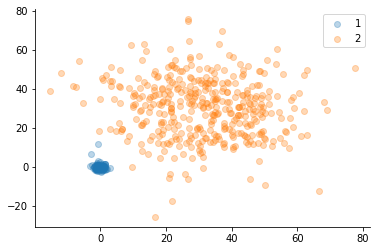

In [ ]:
from scipy.cluster.hierarchy import fcluster
labels = fcluster(Z, 400, criterion='distance')
plot_clustering(data, labels)

Previously, we chose the value 400 to cut the dendogram mostly because we knew the right answer.
In the dendogram, the two rightest clusters which merge at around 250 seem to merge from a long distance.
Let's look at what this choice would bring.
Here we limit the clusters at 4.

In this situation, the two clusters that merge from far away are the green and red, which indeed were quite far.
This happen because the natural cluster was very large.
The algorithm starts by creating subclusters that are close together, mostly because of statistical fluctuation.
Because of these fluctuations, there may be a point were the algorithm will need to merge far away clusters in order to recreate the natural one.

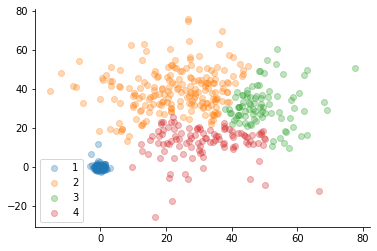

In [ ]:
from scipy.cluster.hierarchy import fcluster
labels = fcluster(Z, 4, criterion='maxclust')
plot_clustering(data, labels)

## HDBSCAN

[HDBSCAN](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html) is a mix between DBSCAN and hierarchical clustering.
Here we will discuss the intuition behind the algorithm and not the actual implementation.
The students can find another comprehensive presentation on the following [ressource](https://www.youtube.com/watch?v=dGsxd67IFiU).
When performing DBSCAN with an extremely small ```eps```, every point is its own cluster.
With increasing ```eps```, some points will be in sufficiently dense area such that they will be merged into a single larger cluster.
As a result, we get a hierarchical construction : small clusters merge into a larger clusters.
This process can be repeated until large values of ```eps``` where all points are within a single cluster.

From this process, we get a hierarchical tree, similar to what we get from hierarchical clustering, but based on density instead of distance.
But then comes the step of choice.
If we cut the tree at some value of density, this is equivalent to applying a DBSCAN with a specific ```eps```.
HDBSCAN can then help finding a decent value for ```eps```.
However it was mentionned that the analyst can cut any branch at any level, provided that cutting a branch means keeping everything below in a single cluster.
HDBSCAN makes this step for the user.
The algorithm possesses a heuristic that defines the best clusters. 
Basically, the best cuts are the ones that tries to maximise the total length of branches.


Even though HDBSCAN removes the burden of choosing ```eps``` for the analyst, there remains a couple of parameters to set in order to fine tune the results. ```min_samples``` is exactly the same as the one of DBSCAN.
It defines how much points need to be in each other neighbourhoods in order to create a cluster candidate instead of noise.
```min_cluster_size``` is a similar but different parameter.
This parameter force the cut not to consider small clusters as final ones if they merge into a larger one, even if it was favorable in term of line length.
It is in some way a regularisation parameter.

In this first example, the algorithm correctly extract the orange cluster, which is well separated, and noise points around it looks ok.
However, the two rightmost clusters are too close together.
Because HDBSCAN is based on density like DBSCAN, creating each cluster separately and merging them must happen around the same ```eps``` so the algorithm has a hard time extracting them.

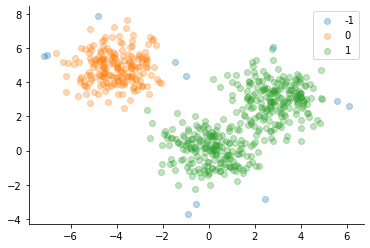

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
import hdbscan
data, labels = make_blobs(n_samples=[200, 200, 200], 
                          random_state=12,
                         centers = [[-4, 5], [0, 0], [3, 3]], 
                         cluster_std=[1, 1, 1])

clst = hdbscan.HDBSCAN().fit(data)
plot_clustering(data, clst.labels_)

Then we look at how the algorithm manages to extract one large and one small cluster.
Here, we saw that DBSCAN had a trouble because each cluster needed a different ```eps```.
This is were HDBSCAN works well without any particular tuning.

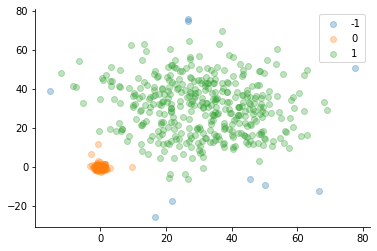

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[100, 400], 
                          random_state=12,
                         centers = [[0, 0], [30, 30]], 
                         cluster_std=[1, 15])

clst = hdbscan.HDBSCAN().fit(data)
plot_clustering(data, clst.labels_)

## Clusters quality

So far we have mainly described the algorithms and their respective limitations.
We have discussed how the tuning of the parameters will drastically change the final clusters.
However, we have not discussed how to evaluate the quality of the clusters, how to choose the correct values for the parameters.
This section aims at providing insight at several techniques of evaluation and understanding of clusters.
This [ressource](https://www.youtube.com/watch?v=Mf6MqIS2ql4) propose an additional discussion on this topic.

### Check it out

The first way to evaluate the quality of the clustering is to leverage the analyst.
If the data is in 2D, it is easy to plot it and the corresponding labels, like in the previous section, to estimate the quality of the clustering.

When data has more dimensions, this strategy is a bit more complicated.
It is important to notice that even though only 2D examples have been shown for pedagogical purposes, clustering may be applied in any dimension.
Computing distance between points in 2 or 20 dimension is no different.
Applying clustering in more dimensions may be a choice if one does not want to change the notion of distance before the clustering algorithm

In the situation of large dimension, the analyst may perform a dimension reduction afterwards in order to see how clusters are grouped.
It is important to note that because the distance in the embedding is not the same as in the high dimension, there may be a distortion (for the better or the worse) of the clusters.
You can see the example in the course of dimension reduction where the embedding space has the same size as the inital space.
Let's look how would appear a clustering of fussy clusters after dimension reduction.
Of course, it is also possible to perform first dimension reduction and then apply clustering, as long as the analyst keep in mind the deformation induced by the reduction.

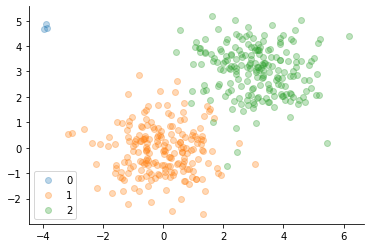

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[3, 200, 200], 
                          random_state=12,
                         centers = [[-4, 5], [0, 0], [3, 3]], 
                         cluster_std=[0.2, 1, 1])
plot_clustering(data, labels)

/mnt/c/Users/christophe_goudet/Documents/dev/esilv/venv/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


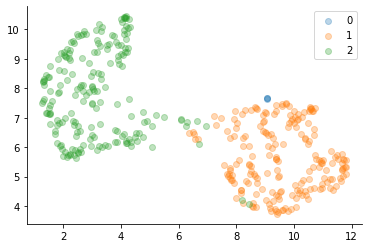

In [ ]:
from umap import UMAP
red = UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=20)

transformed1 = red.fit_transform(data)
plot_clustering(transformed1, labels)

In this example, the green and orange clusters have been further divided than they are in reality.
Still, there are some points at the transition.
The blue cluster of outliers have been incorporated to the orange cluster and are not an independent cluster anymore.
Here, the dimension reduction technique have exacerbated some features but has also destroyed others.

### WSS method

The elbow method takes the following assumption : good clusters are dense.
Then, points should be close to the center of the cluster.

For a given set of parameters of a clustering algorithm, we can estimate the centroid of each cluster (in the same sense as KMeans).
Then we can compute the distance of each point with respect to its assigned centroid.
This quantity is called the 'within cluster sum of square' (WSS).

If we select the parameters so that each point is its own cluster, then the WSS will be 0.
As we decrease the number of clusters, this number will increase.
But as long as the newly created cluster include close points, the increase will be small.
At some point, there will be less cluster achievable by the algorithm than the natural number.
Then, the WSS will increase fast because one cluster may consist of multiple clusters far from each other.

The elbow method takes its name from the shape of the curve we expect.
Because we expect a sharp increase in the WSS when the number of clusters is below the natural clusters, the best parameter is taken as the one when increasing the number of clusters would not reduce much the WSS.

Let's take a simple example on well defined clusters.

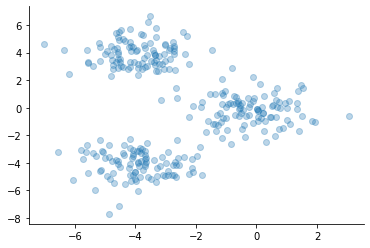

In [ ]:
from sklearn.datasets import make_blobs
limit = 4
data, labels = make_blobs(300, random_state=12,
                         centers = [[0, 0], [-limit, limit], [-limit, -limit]])
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], alpha=0.3);

We will apply a KMeans algorithm to this dataset.
We will test multiple values of the number of clusters and check the ```inertia_``` already implemented in sklearn.
As expected, there is a sharp decrease of the WSS for small number of clusters.
This is because when two natural clusters are merged into a single one, the centroid will be in the void space in between them and all points will be far from it.
Starting from 3 clusters, the curve continue to decrease but at a much lower rate.
There is a clear break of behaviour at the value 3 : this is our optimal number of clusters.
In practice, the transition will always be more fuzzy.
A bit of exploration can be required to identify the best numbers.

Text(0, 0.5, 'WSS')

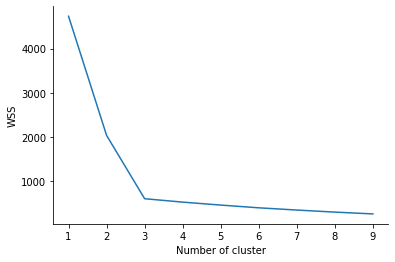

In [ ]:
res = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(data)
    res.append((k, kmeans.inertia_))

fig, ax = plt.subplots()
ks, inertias = zip(*res)
ax.plot(ks, inertias)
ax.set_xlabel("Number of cluster")
ax.set_ylabel("WSS")

#### Different scales

The WSS informs the analyst about the average density of the clusters, not about their delimitation.
This can lead to the following situation.

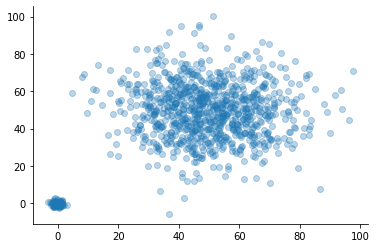

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[100, 900], 
                          random_state=12,
                         centers = [[0, 0], [50, 50]], 
                         cluster_std=[1, 15])
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], alpha=0.3);

In [ ]:
from scipy.spatial.distance import cdist

res = []
for eps in np.linspace(0.1, 8, 11):
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(data)
    
    uniques = np.unique(labels[labels!=-1])
    wss = 0
    for label in uniques:
        mask = labels == label
        centroid = data[mask].mean(0)
        dists = cdist(data[mask], [centroid])
        wss += dists.sum()
    
    res.append((eps, wss, len(uniques)))

In [ ]:
eps, wss, n_clusters = zip(*res)

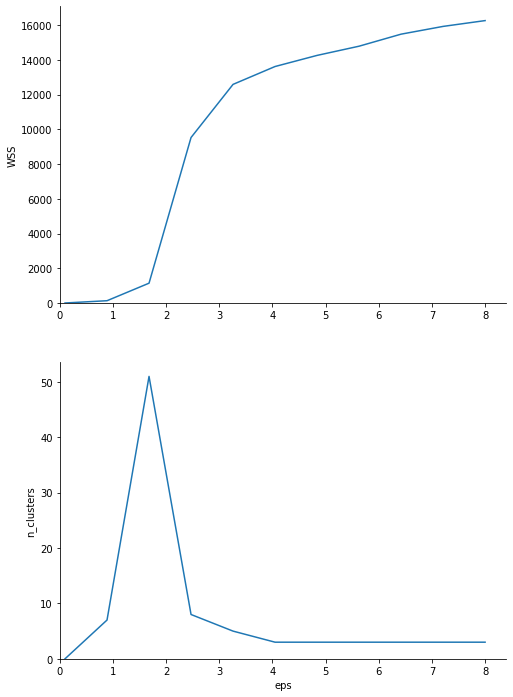

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(8, 12))
ax0.plot(eps, wss)
ax0.set_ylabel('WSS')
ax0.set_ylim(0,None);
ax0.set_xlim(0,None);

ax1.plot(eps, n_clusters)
ax1.set_xlabel('eps')
ax1.set_ylabel('n_clusters');
ax1.set_ylim(0,None);
ax1.set_xlim(0,None);

With this example we see that with increasing ```eps```, the WSS keeps increasing.
We could conclude that large ```eps``` values create meaningless clusters and that a value around 50 would be best.
However, we also see that for ```eps=2``` the number of clusters is very high and decreases very sharply.
The very low number of clusters for large ```eps``` is expected as with a large enough value, all points will be in a single cluster.

So, do we really have 50 clusters in this dataset?
The following figure shows the clustering obtained with ```eps=8```, which is supposed to be extremely bad.
If we look at it, it is actually excellent apart from a couple of outliers and the cluster 2.
So what has happened?
Because the orange cluster is exremely large, most points are very far from the centroid.
The WSS does not care about the overall coherence of the cluster. 
What matter is the absolute distance to the centroid.

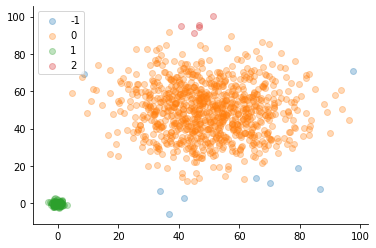

In [ ]:
dbscan = DBSCAN(eps=8)
labels = dbscan.fit_predict(data)
plot_clustering(data, labels)

#### not circular shapes

Because the metric is based on distance, it is optimised for circular clusters.
A well defined cluster but with a longish or more complex shape would not have a good score.

In the case of the moon dataset, the centroid are not even within the cluster.
Then all data points are far from it.

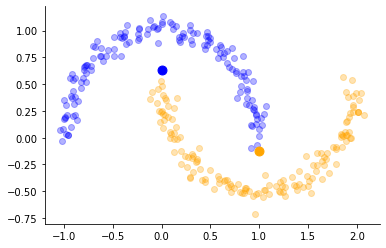

In [ ]:
from sklearn.datasets import make_moons
data, labels = make_moons(300, noise=0.06, random_state=33)

fig, ax = plt.subplots()
colors = ['blue', 'orange']
for i, c in enumerate(range(2)):
    mask = labels==c
    ax.scatter(data[mask,0], data[mask,1], alpha=0.3, color=colors[i])
    
    centroid = data[mask].mean(0)
    ax.scatter([centroid[0]], [centroid[1]], color=colors[i], s=80)

### Silhouette

The silhouette score is another metric used to assess the quality of clusters.
This score combines both the information within a cluster but also the information from different clusters.
It computes the average distance of a point with respect to all other points in the same cluster $a_i$ and the average distance to points in the closest neighbour cluster $b_i$.
Then, these two quantities are compared with the below formula.

$$S = \frac{1}{N}\sum\limits_{i=0}^{N} \frac{b_i-a_i}{max(b_i, a_i)}$$

If the point $i$ is well within its cluster, and far from another cluster, the silhouette score is 1.
If the point is at the same distance of both clusters in average, this value will be 0.
Then the value will be negative if the point is closer to the neighbour cluster.

The interesting part of silhouette is that it takes into account the ambiguity of points with respect to their clusters.
If a point is far from the other points of the cluster, but even further away from the next cluster, it is still considered well classifed.
On the opposite, two small cluster close together will have many points that are close to both clusters, hence giving a lower score.

Let's take again the example of the large and small clusters.
If the large cluster was shifted, that would not change the distances of each point with respect to the centroid.
However, points which are at the frontier of the orange cluster would then be further away from the blue cluster and their silhouette score would improve.

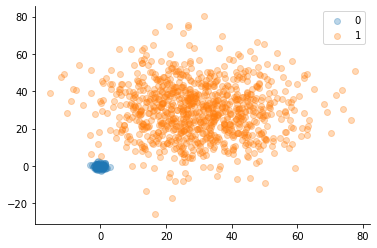

In [ ]:
data, labels = make_blobs(n_samples=[100, 900], 
                          random_state=12,
                         centers = [[0, 0], [30, 30]], 
                         cluster_std=[1, 15])
plot_clustering(data, labels)

We can make a plot that shows the silhouette score for every single points in the dataset.
Let's first look at the bottom blue part.
There is a blue line for each point in the blue cluster, which length is the silhouette score.
Here the blue cluster is very compact, so each point is extremely close to other blue points, and in average very far from orange points.
As a result, all blue points have a very high silhouette score.
This cluster is of very high quality.

Then let's look at the orange part.
We see this negatives scores at the bottom.
This means that many points are more likely badly clustered.
Indeed, the leftmost points of the orange cluster are closer to the blue points than of the orange ones.
Given the definition of silhouette, it is expected that they have a bad score.
Concerning the top points, we see that they are not that well scored.
It is also understandable. 
If one take on point on the far right, it is indeed well classified.
However, the orange blob is so large that the average of the cluster is only at half the distance of the blue cluster.
Hence we expect a silhouette of $s=\frac{2d-d}{2d}=0.5$, which is roughly what we get.

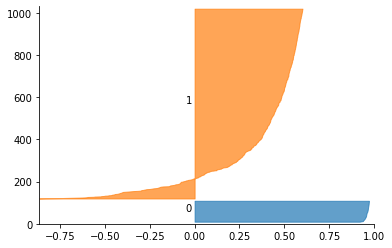

In [ ]:
draw_silhouette(data, labels)

Let's now look what would happen if the orange cluster was just further away.

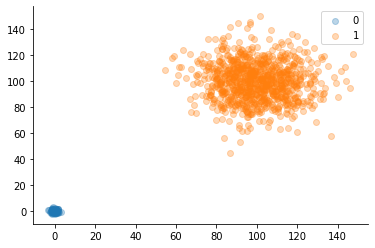

In [ ]:
data, labels = make_blobs(n_samples=[100, 900], 
                          random_state=12,
                         centers = [[0, 0], [100, 100]], 
                         cluster_std=[1, 15])
plot_clustering(data, labels)

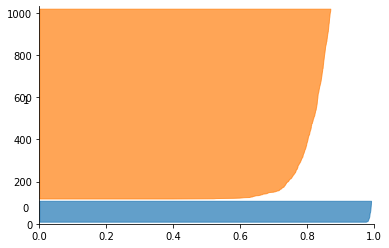

In [ ]:
draw_silhouette(data, labels)

Now almost all orange points have a very good score.
Indeed, even the closest points of the blue cluster are still very far compared to their colleagues.
We also see that the maximum value for orange is closer to 1 but still significantly lower.
This tells us that the distances within this cluster are larger than in the blue cluster.

The silhouette score still suffer in some degree from the notion of distance.
The score will not provide great values for non circular cluster, even though the clustering may be perfect like in the moon dataset.
As we have seen, it also shows limitation when cluster have different sizes.
Finally, we have seen that fuzzy clusters will not get a good score.

However the silhouette plot bring much information that can help the analyst understand the data.
* In the previous example, we have seen that the blue cluster had a very high score while the orange was much lower.
In practice, it is expected that some clusters are very well defined, while other are fuzzier.
The silhouette plot allows to differentiate those type of cluster, which could trigger further analyses.

* In the case of fuzzy clusters, the silhouette score help us determine which are the transition points.
Those points may have an interesting business values as they belong to multiple clusters.

* We have seen that the silhouette score may give a rough understanding of the size of the cluster if we have an idea of the distance between centroids.

### Check the business value

The analyst can check not whether the clustering creates well defined cluster but if the different groups have a business meaning.
In the situation of fuzzy clusters, the visualisation of the clusters may not be good.
The mathematical estimation will definitely not be good.
However, it is possible that those low quality clusters have a high business value.

Check for example the example from the embedding of the breast cancer data from the course on dimension reduction.
If we only looked at the embedding, there was vaguely two or three clusters but the transition was not so good.

![](../../figures/cancer_embedding.png)


However, when we looked at the same embedding with the angle of diagnosis, we saw that each side of the embedding had a very clear meaning.
The vague transition was just the normal behaviour of the continuous nature of the risk of cancer from very high to very low.
Even if the clustering algorithm has difficulties to find where the two clusters end, there will be great value as long as the main part of each blob are well defined.

![](../../figures/cancer_embedding_diagnosis.png)

### Don't get all clusters

Data does not always have nice clusters. 
Nice clusters can cohabit with large unstructured space.
Most algorithm will try to make something of those large spaces.
A bad clustering score for some cluster doesn't mean that there is a cluster that the algorithm has difficulties identifying.
This could also be a situation where there is not real cluster but the algorithm managed to find something because it had to.

Always keep in mind that it's not because we apply an algorithm on a dataset that the dataset exhibit the best behaviour for this algorithm.
Maybe just a subset of the dataset has the property and it's good enough to study this part.

## Conclusion

The purpose of clustering is to identify groups of similar points, separated from the rest of the dataset.
These groups of homogenous points may be used as such or reintegrated into a machine learning pipeline.

There exist a multitude of algorithms to identify these groups.
They are based on different assumptions about the data hence give widely different results, and require different thinking in order to tune them.
They can be either based on distances to centroid or agglomerative.
They can create a single set of clusters, or a full hierachy of clusters.
Depending on the data structure, each algorithm will have its strengths and its weaknesses.

Evaluating the quality of the clustering process is quite complicated.
In low dimension, the analyst may visualize the results and tune the analysis to reach the expected results.
In high dimension however, the analyst must rely on dimension reduction to visualize the results, or on statistical metrics.


## Exercices

### Patients

The exercice on dimension reduction allowed us to create an embedding on the data missingness of the patient dataset.
The embedding showed many clusters, more or less separated and in two dimensions.
Compare the various techniques presented on this dataset, which present various real life complications.

### Cancer dataset

We already studied the cancer dataset in the dimension reduction course.
Now perform the complementary analysis.
Apply the various clustering algorithms on the cancer dataset, before any dimension reduction, and compare the results.
Which algorithm seem the most practical.
Is there any clusters in the dataset?
Is there any value in performing clustering on this dataset.